In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, resample
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

In [2]:
data = pd.read_csv("C:/Users/Akif/Desktop/football/rankingv5v5.csv")

In [3]:
selected_columns = [
    'home_club_id', 'away_club_id', 'attendance', 'home_team_points', 'away_team_points',
    'home_attack_value', 'away_attack_value', 'home_midfield_value', 'away_midfield_value',
    'home_defender_value', 'away_defender_value', 'home_goalkeeper_value', 'away_goalkeeper_value',
    'home_total_market_value', 'away_total_market_value', 'home_power_score', 'away_power_score', 'result'
]
data = data[selected_columns]

data = data.dropna()

print("Class distribution before balancing:")
print(data['result'].value_counts())

Class distribution before balancing:
1    8159
2    5358
0    4554
Name: result, dtype: int64


In [4]:
class_0 = data[data['result'] == 0]  # Draw
class_1 = data[data['result'] == 1]  # Home Win
class_2 = data[data['result'] == 2]  # Away Win

In [5]:
max_size = max(len(class_0), len(class_1), len(class_2))
class_0_upsampled = resample(class_0, replace=True, n_samples=max_size, random_state=42)
class_1_upsampled = resample(class_1, replace=True, n_samples=max_size, random_state=42)
class_2_upsampled = resample(class_2, replace=True, n_samples=max_size, random_state=42)

In [6]:
data_balanced = pd.concat([class_0_upsampled, class_1_upsampled, class_2_upsampled])
data_balanced = shuffle(data_balanced, random_state=42)

In [7]:
print("Class distribution after balancing:")
print(data_balanced['result'].value_counts())

Class distribution after balancing:
2    8159
1    8159
0    8159
Name: result, dtype: int64


In [8]:
X = data_balanced.drop('result', axis=1)
y = data_balanced['result']

In [9]:
scaler = RobustScaler()
X = scaler.fit_transform(X)

In [10]:
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.values.reshape(-1, 1))

X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
def build_model(hp):
    model = Sequential()
    
    hp_units = hp.Int('units', min_value=64, max_value=512, step=64)
    model.add(Dense(units=hp_units, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))

    hp_dropout = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp_dropout))

    hp_units_2 = hp.Int('units_2', min_value=64, max_value=256, step=64)
    model.add(Dense(units=hp_units_2, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp_dropout))

    model.add(Dense(3, activation='softmax'))

    hp_learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [12]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  
    executions_per_trial=3, 
    directory='my_dir',
    project_name='football_tuning')


Reloading Tuner from my_dir\football_tuning\tuner0.json
Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

In [14]:
tuner.search(X_train, y_train, epochs=150, validation_data=(X_test, y_test), 
             callbacks=[early_stopping, lr_scheduler])

best_model = tuner.get_best_models(num_models=1)[0]

history = best_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), 
                         callbacks=[early_stopping, lr_scheduler])

Epoch 1/150
574/574 [==============================] - 4s 5ms/step - loss: 0.9433 - accuracy: 0.5608 - val_loss: 0.9639 - val_accuracy: 0.5503 - lr: 5.4209e-05
Epoch 2/150
574/574 [==============================] - 3s 5ms/step - loss: 0.9363 - accuracy: 0.5669 - val_loss: 0.9628 - val_accuracy: 0.5500 - lr: 5.4209e-05
Epoch 3/150
574/574 [==============================] - 3s 5ms/step - loss: 0.9372 - accuracy: 0.5644 - val_loss: 0.9620 - val_accuracy: 0.5523 - lr: 5.4209e-05
Epoch 4/150
574/574 [==============================] - 3s 5ms/step - loss: 0.9299 - accuracy: 0.5729 - val_loss: 0.9604 - val_accuracy: 0.5487 - lr: 5.4209e-05
Epoch 5/150
574/574 [==============================] - 3s 5ms/step - loss: 0.9356 - accuracy: 0.5648 - val_loss: 0.9592 - val_accuracy: 0.5536 - lr: 5.4209e-05
Epoch 6/150
574/574 [==============================] - 3s 5ms/step - loss: 0.9364 - accuracy: 0.5667 - val_loss: 0.9591 - val_accuracy: 0.5498 - lr: 5.4209e-05
Epoch 7/150
574/574 [===================

Epoch 52/150
574/574 [==============================] - 3s 5ms/step - loss: 0.9014 - accuracy: 0.5945 - val_loss: 0.9289 - val_accuracy: 0.5837 - lr: 5.4209e-05
Epoch 53/150
574/574 [==============================] - 3s 5ms/step - loss: 0.8989 - accuracy: 0.5920 - val_loss: 0.9261 - val_accuracy: 0.5810 - lr: 5.4209e-05
Epoch 54/150
574/574 [==============================] - 2s 4ms/step - loss: 0.9011 - accuracy: 0.5948 - val_loss: 0.9273 - val_accuracy: 0.5850 - lr: 5.4209e-05
Epoch 55/150
574/574 [==============================] - 3s 6ms/step - loss: 0.8969 - accuracy: 0.5969 - val_loss: 0.9269 - val_accuracy: 0.5871 - lr: 5.4209e-05
Epoch 56/150
574/574 [==============================] - 2s 4ms/step - loss: 0.8982 - accuracy: 0.5987 - val_loss: 0.9274 - val_accuracy: 0.5886 - lr: 5.4209e-05
Epoch 57/150
574/574 [==============================] - 3s 6ms/step - loss: 0.9063 - accuracy: 0.5896 - val_loss: 0.9273 - val_accuracy: 0.5876 - lr: 5.4209e-05
Epoch 58/150
574/574 [============

Epoch 103/150
574/574 [==============================] - 3s 6ms/step - loss: 0.8711 - accuracy: 0.6114 - val_loss: 0.9043 - val_accuracy: 0.6013 - lr: 2.7105e-05
Epoch 104/150
574/574 [==============================] - 3s 5ms/step - loss: 0.8695 - accuracy: 0.6147 - val_loss: 0.9016 - val_accuracy: 0.6044 - lr: 2.7105e-05
Epoch 105/150
574/574 [==============================] - 2s 4ms/step - loss: 0.8702 - accuracy: 0.6113 - val_loss: 0.9030 - val_accuracy: 0.6025 - lr: 2.7105e-05
Epoch 106/150
574/574 [==============================] - 4s 6ms/step - loss: 0.8671 - accuracy: 0.6129 - val_loss: 0.9042 - val_accuracy: 0.6051 - lr: 2.7105e-05
Epoch 107/150
574/574 [==============================] - 2s 4ms/step - loss: 0.8679 - accuracy: 0.6091 - val_loss: 0.9031 - val_accuracy: 0.6056 - lr: 2.7105e-05
Epoch 108/150
574/574 [==============================] - 4s 6ms/step - loss: 0.8629 - accuracy: 0.6162 - val_loss: 0.9027 - val_accuracy: 0.6028 - lr: 2.7105e-05
Epoch 109/150
574/574 [=====

In [15]:
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes))

192/192 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.63      0.52      0.57      2074
           1       0.63      0.65      0.64      2055
           2       0.61      0.70      0.65      1991

    accuracy                           0.62      6120
   macro avg       0.62      0.62      0.62      6120
weighted avg       0.62      0.62      0.62      6120



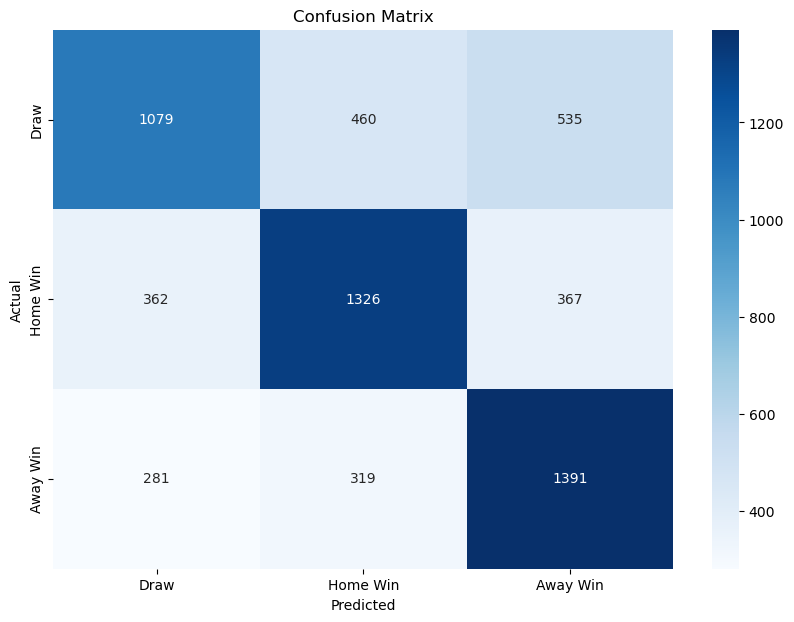

In [16]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Draw', 'Home Win', 'Away Win'],
            yticklabels=['Draw', 'Home Win', 'Away Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [17]:
def predict_match(model, home_team_id, away_team_id, attendance, home_team_points, away_team_points,
                  home_attack_value, away_attack_value, home_midfield_value, away_midfield_value,
                  home_defender_value, away_defender_value, home_goalkeeper_value, away_goalkeeper_value,
                  home_total_market_value, away_total_market_value, home_power_score, away_power_score):

    match_features = np.array([home_team_id, away_team_id, attendance, home_team_points, away_team_points,
                               home_attack_value, away_attack_value, home_midfield_value, away_midfield_value,
                               home_defender_value, away_defender_value, home_goalkeeper_value, away_goalkeeper_value,
                               home_total_market_value, away_total_market_value, home_power_score, away_power_score]).reshape(1, -1)
    
    match_features = scaler.transform(match_features)
    
    prediction = model.predict(match_features)
    
    return prediction

In [18]:
home_team_id = 162
away_team_id = 583
attendance = -0.799500
home_team_points = 0.623097
away_team_points = 1.064934
home_attack_value = 0.186794
away_attack_value = 5.482963
home_midfield_value = -0.697554
away_midfield_value = 0.571892
home_defender_value = 0.511353
away_defender_value = 0.906488
home_goalkeeper_value = -0.172559
away_goalkeeper_value = 0.164418
home_total_market_value = 0.198449
away_total_market_value = 3.077390
home_power_score = 0.152487
away_power_score = 2.597862

prediction = predict_match(best_model, home_team_id, away_team_id, attendance, home_team_points, away_team_points,
                           home_attack_value, away_attack_value, home_midfield_value, away_midfield_value,
                           home_defender_value, away_defender_value, home_goalkeeper_value, away_goalkeeper_value,
                           home_total_market_value, away_total_market_value, home_power_score, away_power_score)

print(f'Prediction: {prediction}')

1/1 [==============================] - 0s 21ms/step
Prediction: [[0.039559   0.06991148 0.8905295 ]]


C:\Users\Akif\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [19]:
print(conf_matrix)

[[1079  460  535]
 [ 362 1326  367]
 [ 281  319 1391]]


In [20]:
import numpy as np

# The scaler you used during training
scaler = RobustScaler()

# Function to convert real-world data into normalized values
def convert_to_normalized(home_team_id, away_team_id, attendance, home_team_points, away_team_points,
                          home_attack_value, away_attack_value, home_midfield_value, away_midfield_value,
                          home_defender_value, away_defender_value, home_goalkeeper_value, away_goalkeeper_value,
                          home_total_market_value, away_total_market_value, home_power_score, away_power_score):
    
    # Create a numpy array with the real-world values
    real_data = np.array([[home_team_id, away_team_id, attendance, home_team_points, away_team_points,
                           home_attack_value, away_attack_value, home_midfield_value, away_midfield_value,
                           home_defender_value, away_defender_value, home_goalkeeper_value, away_goalkeeper_value,
                           home_total_market_value, away_total_market_value, home_power_score, away_power_score]])
    
    # Use the scaler (already fitted) to normalize the real-world data
    normalized_data = scaler.transform(real_data)
    
    return normalized_data

# Modify your predict_match function to normalize inputs before predicting
def predict_match(model, home_team_id, away_team_id, attendance, home_team_points, away_team_points,
                  home_attack_value, away_attack_value, home_midfield_value, away_midfield_value,
                  home_defender_value, away_defender_value, home_goalkeeper_value, away_goalkeeper_value,
                  home_total_market_value, away_total_market_value, home_power_score, away_power_score):

    # Convert real-world data to normalized data
    match_features_normalized = convert_to_normalized(home_team_id, away_team_id, attendance, home_team_points, away_team_points,
                                                      home_attack_value, away_attack_value, home_midfield_value, away_midfield_value,
                                                      home_defender_value, away_defender_value, home_goalkeeper_value, away_goalkeeper_value,
                                                      home_total_market_value, away_total_market_value, home_power_score, away_power_score)
    
    # Pass the normalized data to the model for prediction
    prediction = model.predict(match_features_normalized)
    
    return prediction

# Test prediction with real-world data (not normalized)
home_team_id = 162
away_team_id = 583
attendance = 50000  # Example real-world attendance value
home_team_points = 50  # Example real-world home team points
away_team_points = 45  # Example real-world away team points
home_attack_value = 75  # Real-world home attack value
away_attack_value = 80  # Real-world away attack value
home_midfield_value = 70  # Real-world home midfield value
away_midfield_value = 75  # Real-world away midfield value
home_defender_value = 68  # Real-world home defender value
away_defender_value = 72  # Real-world away defender value
home_goalkeeper_value = 60  # Real-world home goalkeeper value
away_goalkeeper_value = 65  # Real-world away goalkeeper value
home_total_market_value = 300  # Example real-world market value
away_total_market_value = 350  # Example real-world market value
home_power_score = 80  # Real-world power score
away_power_score = 85  # Real-world power score

# Get prediction using real-world values
prediction = predict_match(best_model, home_team_id, away_team_id, attendance, home_team_points, away_team_points,
                           home_attack_value, away_attack_value, home_midfield_value, away_midfield_value,
                           home_defender_value, away_defender_value, home_goalkeeper_value, away_goalkeeper_value,
                           home_total_market_value, away_total_market_value, home_power_score, away_power_score)

print(f'Prediction: {prediction}')


NotFittedError: This RobustScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.